# Kickstarter: What Makes Projects Succeed/Fail?
Inna Shteinbuk (ibs26) & Huai-Che Lu (hl938)

## Introduction
Crowdfunding is the practice of raising venture from the general public. Sites like [Kickstarter](https://www.kickstarter.com/) and [Indiegogo](https://www.indiegogo.com/) provide internet-mediated services to support the process of requesting and offering monetary help. In this project, we looked into different textual and social factors to see how they relate to the success or failure of projects.

On Kickstarter, creators launch projects where they can talk about the products and demonstrate the progress to attract backers' willingess to fund the projects. In return, creators give backers different rewards based on the sponsored amount. It's notable that the pledge rewards come with a delay after the backers provide the money, which is largest difference between crowdfunding sites and other e-commerce services.

## Related Work
Althoff et al. looked at [Random Acts of Pizza (RAOP)](http://randomactsofpizza.com/) to see the textual and social factors that influence the success of altruistic requests[1]. In RAOP, requesters ask for pizzas. Serveral factors like politeness, evidentiality, reciprocity, sentiment, and length; status, similarity were taken into consideration. 

Mitra et al. also discussed the language on Kickstarter [2].

## Research Questions
Differences between Kickstarter and RAOP:
1. Mutual-beneficial vs. Altruistic
2. Diversed content vs. Pizza

We're interested in how the information shown on Kickstarter affect the creator-backer dynamic on the site.

## Hypotheses

- The whole dataset
    - **H1 [Trust]: ** Project creators are asking more money overtime.
    - **H2 [Reputation]: ** Project creators with good records are more likely to get help.
- Tech dataset 
    - **H3 [Reciprocity]: ** People who have already been backed, are more likely to back other projects.
    - **H4 [Similarity] **
        - ** H4.1 (Interest-based): ** People are more likely to back projects in the same category as the projects they’ve created.
        - ** H4.2 (Location-based): ** People are more willing to back creators from the same country.
    - **H6: Effort**
    - **H7: Language**

## Data
### Original Data

### Scraped Data
In additional to the original data, we wrote our own scrapers to get more information on a subset of the original dataset. The following information was collected:
- Numerical
    1. Projects that creators backed
- Textual
    1. Full project description
    2. Risks and challenges

## H1: Trust
Project creators are willing to ask for more money overtime.

In [269]:
import time
import json
from collections import Counter
from datetime import datetime

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('ggplot')

In [137]:
df = pd.read_csv('data/Kickstarter_all.csv', encoding='utf-8', index_col=0)
df.drop_duplicates(inplace=True)
df = df[(df.state == 'successful') | (df.state == 'failed')]
df.sort_values(by='created_at', inplace=True)

In [138]:
def timestamp2monthstr(t):
    d = datetime.fromtimestamp(t)
    return "%d/%d" % (d.month, d.year)
def monthstr2timestamp(s):
    first_day = '1/' + s
    return time.mktime(datetime.strptime(first_day, '%d/%m/%Y').timetuple())

df['created_month'] = df.created_at.apply(timestamp2monthstr)

In [130]:
def plot_trust(df, key):
    gb = df.groupby(key)
    mean_goals = gb.apply(lambda g: np.mean(g.goal))
    
    timestamps = [monthstr2timestamp(key) for key, g in gb]
    mean_goals = [mg for mg in mean_goals]
    
    df_plot = pd.DataFrame()
    df_plot['mean_goal'] = pd.Series(mean_goals)
    df_plot['timestamp'] = pd.Series(timestamps)
    df_plot.sort_values(by='timestamp', inplace=True)
    
    def millions(y, pos):
        'The two args are the value and tick position'
        return '$%dK' % (y * 1e-3)

    def timestamp_formatter(t, pos):
        return timestamp2monthstr(timestamps[pos]) if pos % 3 == 0 else ""

    plt.figure()
    ax = df_plot.plot.bar(x='timestamp', y='mean_goal', figsize=(16, 8))
    ax.set_ylabel('Mean Goal (USD)')
    ax.set_xlabel('Time')
    ax.yaxis.set_major_formatter(FuncFormatter(millions))
    ax.xaxis.set_major_formatter(FuncFormatter(timestamp_formatter))
    plt.show()

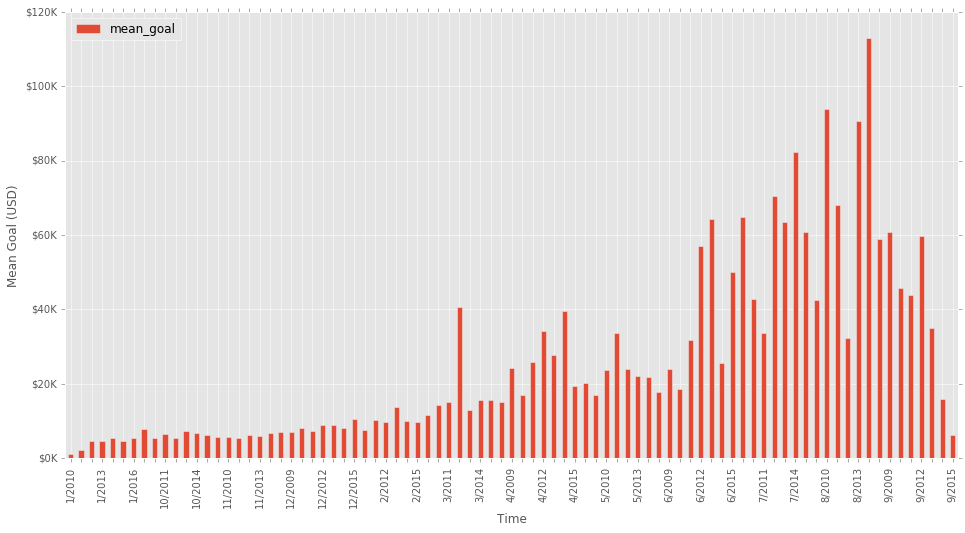

In [131]:
plot_trust(df, 'created_month')

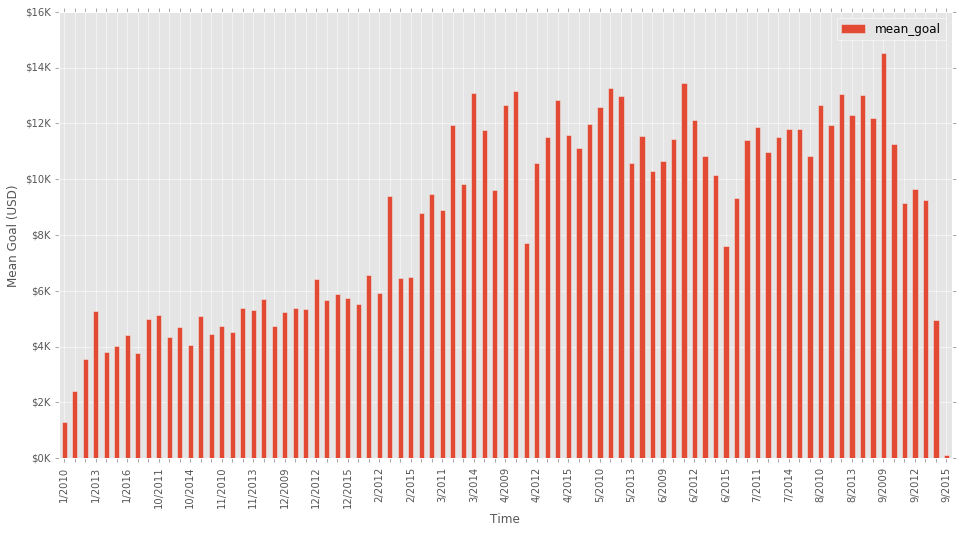

In [128]:
plot_trust(df[df.state == 'successful'], 'created_month')

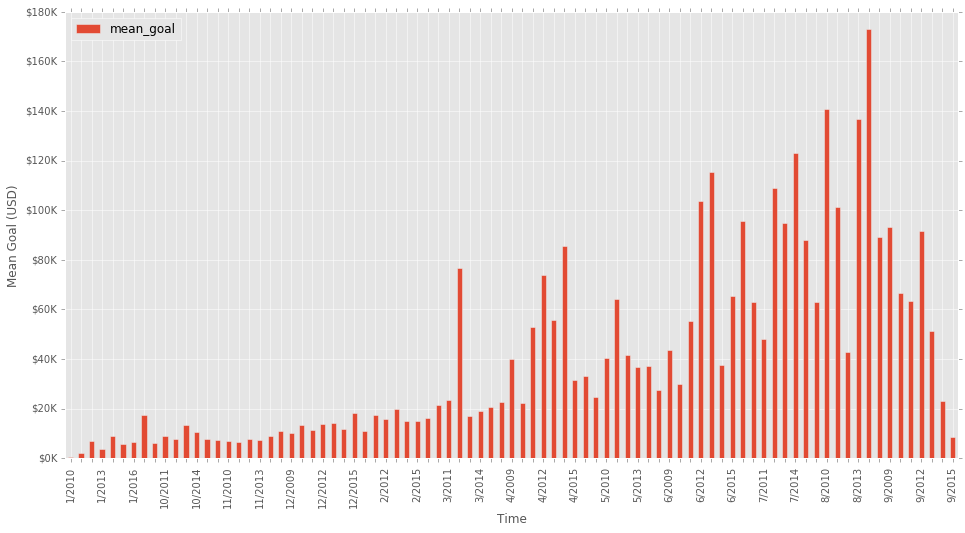

In [129]:
plot_trust(df[df.state == 'failed'], 'created_month')

## H2: Reputation
** Project creators with good records are more likely to get help. **

Due to the nature for crowdfunding, there's risks that the project won't be carried out. Therefore, 
We looked at people who have created more than 3 projects, and see whether the success rate of thier first 3 projects (priors) correlates to that of the rest of the projects (subsequents). The data showed that the correlation coefficient between the prior and subsequent succcess rate was 0.652, which could be interpreted as highly correlated. Therefore, the data also supported this hypothesis.

In [207]:
df = pd.read_csv('data/Kickstarter_all.csv', encoding='utf-8', index_col=0)
df.drop_duplicates(subset=['project_url'], inplace=True)
df.sort_values(by='created_at', inplace=True)

In [213]:
df.get(['created_at', 'creator_id']).head()

,created_at,creator_id
2021,1240335335,williambrittelle
276,1240366270,Samplefreq
3767,1240514851,1309681027
1426,1240600507,darkpony
1689,1240637870,dphiffer


Group the data by creator's id, and take those who have created more than 3 projects into consideration.

In [251]:
gb_id = df.groupby('creator_id') \
    .filter(lambda g: len(g) > 3) \
    .groupby('creator_id')

In [261]:
print(str(len(gb_id)) + " project creators.")

1033 project creators.


In [252]:
def success_rate(states):
    states = Counter(states)
    return float(states['successful']) / sum(states.values())

In [253]:
df_stats = pd.DataFrame()
df_stats['prior'] = gb_id.apply(lambda g: success_rate(g.state.values[:3]))
df_stats['subsequent'] = gb_id.apply(lambda g: success_rate(g.state.values[3:]))

In [286]:
corrcoef = np.corrcoef(df_stats.prior, df_stats.subsequent)[0, 1]
print("Correlation coefficient r = %.3f" % (corrcoef))

Correlation coefficient r = 0.652


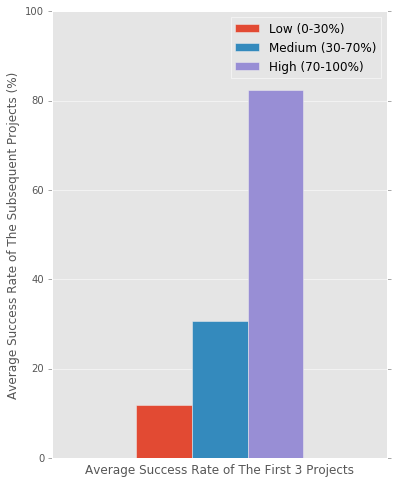

In [273]:
df_plot = pd.DataFrame({'Low (0-30%)': [np.mean(df_stats[df_stats.prior < .3].subsequent)],
                        'Medium (30-70%)': [np.mean(0.3 <= df_stats[df_stats.prior < .6].subsequent)], 
                        'High (70-100%)': [np.mean(df_stats[.6 <= df_stats.prior].subsequent)]})
def percentage(x, pos):
    return '%d' % (x * 100)

plt.figure()
ax = df_plot.plot.bar(figsize=(6, 8), y=['Low (0-30%)', 'Medium (30-70%)', 'High (70-100%)'])
ax.set_ylabel('Average Success Rate of The Subsequent Projects (%)')
ax.set_xlabel('Average Success Rate of The First 3 Projects')
ax.set_ylim(bottom=0.0, top=1.0)
ax.yaxis.set_major_formatter(FuncFormatter(percentage))
ax.set_xticks([])
plt.show()

## H3: Reciprocity

## H4: Similarity

Past research in social psychology has shown that people are more willing to help those who are similar to themselves [3]. Based on this theory, we developed 2 hypotheses to see if this phenomenon also apply to the online crowdfunding context.

## H4.1: Similarity (Interest-Based)
** Creators are more likely to back projects in the same category as the projects they’ve created. **

First, we think that people's inters

## H4.2: Similarity (Location-Based)
** People are more willing to back creators from the same country they are from. **

Second, we thought that location might be an important factor that. For example, if there are 2 similar projects A and B. The creator of A is from Canada, while that of B is from Australia. Based on this hypothesis, there will be more Canadian backers of project A, and more Australian backers for project B.

The result showed that more than 60% of the backers were from the same country as the project creators among all projects in the Tech dataset, which we considered as a support of H4.2. However, there might be a confounding variable.

In [163]:
df = pd.read_csv('data/Kickstarter_Tech.csv', encoding='utf-8', index_col=0)

In [164]:
df.sort_values(by='top_countries').get(['location', 'top_countries']).head() # For visualization

,location,top_countries
1928,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...","[[""AR"", 10], [""US"", 10], [""SG"", 1], [""GB"", 1]]"
9188,"{""country"":""AT"",""urls"":{""web"":{""discover"":""htt...","[[""AT"", 18], [""US"", 4], [""DE"", 1], [""KR"", 1], ..."
5484,"{""country"":""AT"",""urls"":{""web"":{""discover"":""htt...","[[""AT"", 25], [""DE"", 1], [""US"", 1]]"
4989,"{""country"":""AU"",""urls"":{""web"":{""discover"":""htt...","[[""AU"", 102], [""US"", 15], [""GB"", 14], [""SG"", 6..."
6932,"{""country"":""AU"",""urls"":{""web"":{""discover"":""htt...","[[""AU"", 10], [""US"", 1]]"


In [171]:
creator_country_series = df.location.apply(lambda x: json.loads(x)['country'])
backer_countries_series = df.top_countries.apply(lambda x: Counter(dict(json.loads(x))))

In [185]:
similarities = []
for cc, bcs in zip(creator_country_series, backer_countries_series):
    total = sum(bcs.values())
    if cc in bcs:
        similarities.append(bcs[cc] / float(total))
    elif total > 0:
        similarities.append(0.0)
    else:
        similarities.append(np.nan)
similarities = np.array(similarities)

In [280]:
nan_count = np.sum(np.isnan(similarities))
print("%d projects didn't have any backers at all." % (nan_count))
zero_count = np.sum(similarities == 0.0)
print("%d projects didn't have any backers from the same country." % (zero_count))

9153 projects didn't have any backers at all.
58 projects didn't have any backers from the same country.


In [279]:
mean_similarity = np.mean(similarities[np.logical_not(np.isnan(similarities))])
print("%2.1f%% of backers are from the same country as the project creator." % (mean_similarity * 100))

64.7% of backers are from the same country as the project creator.


## H6: Effort

## H7: Language

## Conclusions


## References
1. Althoff, T., & Danescu-Niculescu-Mizil, C. (2014). How to ask for a favor: A case study on the success of altruistic requests. arXiv.org.
2. Mitra, T., & Gilbert, E. (2014). The language that gets people to give: phrases that predict success on kickstarter (pp. 49–61). Presented at the CSCW '14: Proceedings of the 17th ACM conference on Computer supported cooperative work & social computing, ACM. http://doi.org/10.1145/2531602.2531656
3. Ammons Scientific - Psychological Reports - 55(1):139 - PDF. (1984). Ammons Scientific - Psychological Reports - 55(1):139 - PDF. http://doi.org/10.2466/pr0.1984.55.1.139